# Image Stitching using SIFT

Your phone can take a series of photos or a video and convert it into a panoramic image. I'm going to try and recreate that here in this notebook. I have this clean video of a beautiful landscape in Greece (courtesy of my brother-in-law), which I'll convert into a panorama using SIFT.

In [1]:
import cv2
import numpy as np
from anutils import data_path
from anutils.cv import rect, homogenize, unhomogenize
from IPython import display as disp
from matplotlib import pyplot as plt

# Configuration
fa, fb = figscale = (7, 2)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (4 * fa // fb, 3 * fa // fb)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
np.set_printoptions(precision=2)

def disprgb(image):
    rgbim = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgbim)
    plt.show()

def disp_kps(image, keypoints):
    d_img = image.copy()
    cv2.drawKeypoints(d_img, keypoints, d_img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    disprgb(d_img)
    

video_file = data_path / 'image-stitching-example.mp4'
frames_path = data_path / 'frames'

disp.Video(str(video_file), embed=True)

First off, we'll split the video into several individual frames that we can stitch together. We'll use ffmpeg to do this (so this notebook requires ffmpeg)

In [2]:
%%bash

TIME_START=1.5
FRAMES_DIR=frames
FRAME_RATE=1
EXTENSION="jpeg"

pushd ../../data

if [ -d $FRAMES_DIR ]; then
    rm -f $FRAMES_DIR/*.$EXTENSION
else
    mkdir $FRAMES_DIR
fi

ffmpeg -i image-stitching-example.mp4 -ss $TIME_START -r $FRAME_RATE $FRAMES_DIR/image-stitching-example-%02d.$EXTENSION

# for some reason the first frame seems to be duplicated, so we'll remove it and start at 2 \-_-/
rm $FRAMES_DIR/image-stitching-example-01.$EXTENSION

popd

~/Documents/GitHub/andys-notebook/data ~/Documents/GitHub/andys-notebook/notebooks/image-processing-and-computer-vision


ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.3.0-6ubuntu2~24.04)
configuration: --prefix=/usr/local --enable-gpl --enable-libx264
  libavutil      59. 39.100 / 59. 39.100
  libavcodec     61. 19.100 / 61. 19.100
1.  7.100 / 61.  7.100
  libavdevice    61.  3.100 / 61.  3.100
.100bavfilter    10.  4.100 / 10.  4
  libswscale      8.  3.100 /  8.  3.100
  libswresample   5.  3.100 /  5.  3.100
    58.  3.100 / 58.  3.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'image-stitching-example.mp4':
  Metadata:
   : isom_brand  
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
vf61.7.100r         : La
  Duration: 00:00:12.01, start: 0.000000, bitrate: 1076 kb/s
  Stream #0:0[0x1](und): Video: h264 (High 10) (avc1 / 0x31637661), yuv420p10le(tv, bt2020nc/bt2020/arib-std-b67, progressive), 1280x720, 1072 kb/s, 29.97 fps, 29.97 tbr, 30k tbn (default)
ata:  Metad
        handler_name    : Core Media Video
        vendor_id       : [0]

~/Documents/GitHub/andys-notebook/notebooks/image-processing-and-computer-vision


Next up let's read the first frame in

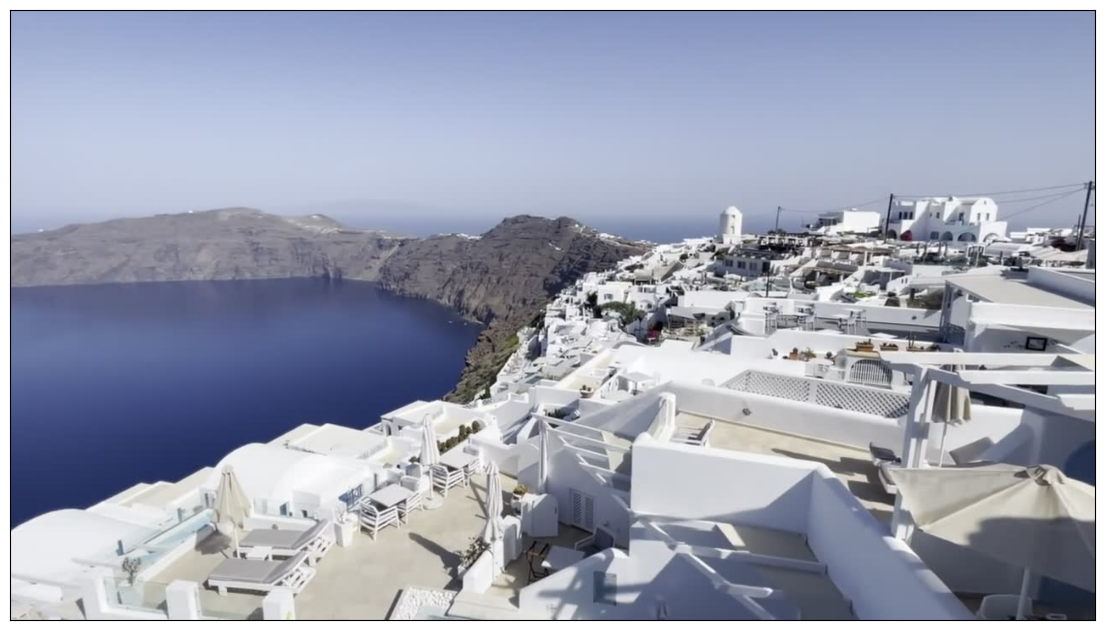

In [3]:
frames = sorted(list(frames_path.iterdir()))
first_frame = frames[0]
img = cv2.imread(str(first_frame))

disprgb(img)

We'll then use SIFT to find some keypoints in this image. We'll keep the number of points to a small amount to make this faster. However one other thing to consider is the direction of your next image being stitched. We want the detector to focus on the left side of our image, as that side will more likely show up in our next image. Thus, we're going to mask the right half of the image

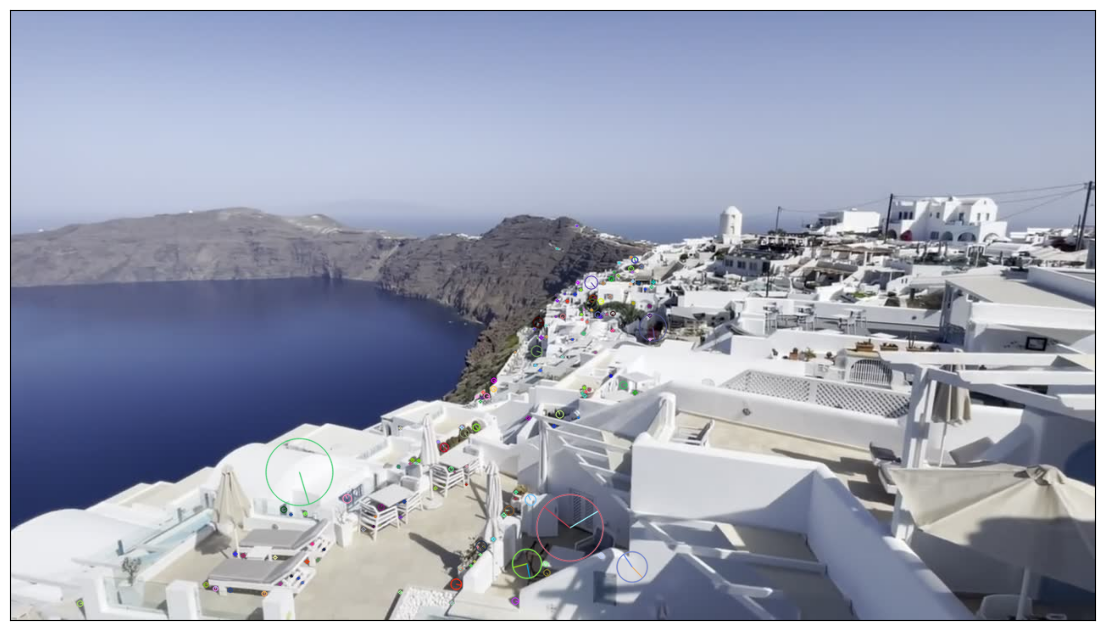

In [4]:
sift = cv2.SIFT.create(nfeatures=500)

mask_half = int(img.shape[1] * 0.6)
im_mask = np.zeros(img.shape[:2], dtype=np.uint8)
im_mask[:,:mask_half] = 255
keypoints, descriptors = sift.detectAndCompute(img, im_mask)

disp_kps(img, keypoints)

Next image! We'll do the same thing except we'll run SIFT for the entire image

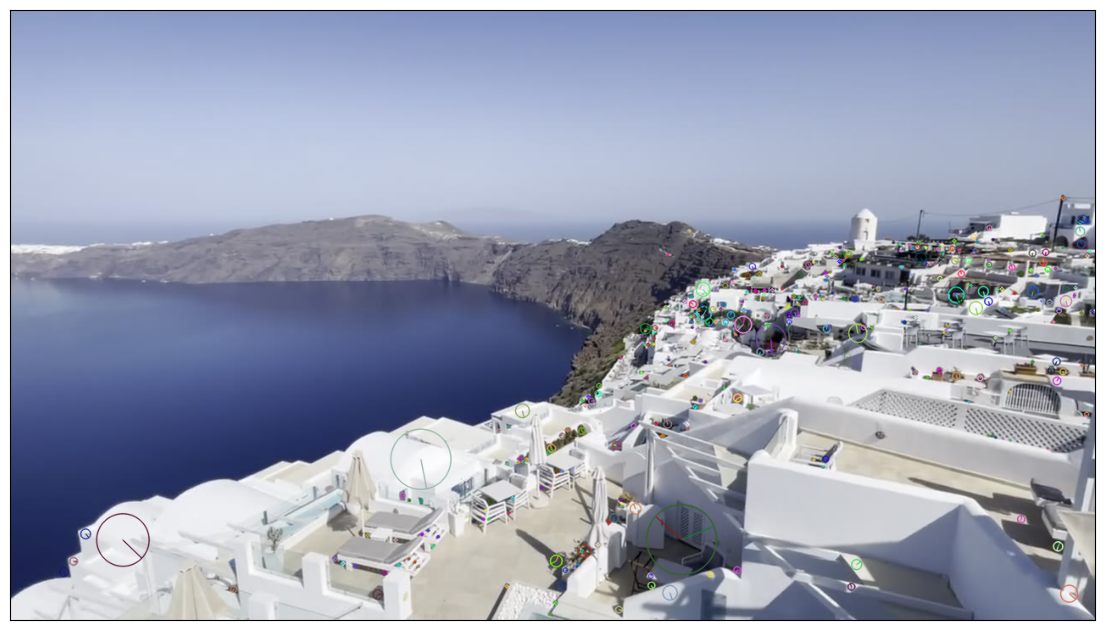

In [5]:
second_frame = frames[1]
img2 = cv2.imread(str(second_frame))

keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

disp_kps(img2, keypoints_2)

Now we'll try to match

In [6]:
matcher = cv2.BFMatcher()

match_groups = matcher.knnMatch(descriptors_2, descriptors, k=2)
matches = [ a for a,b in match_groups if b.distance > 0 and a.distance/b.distance < 0.5 ]

d_img = img.copy()
d_img = cv2.drawMatches(img2, keypoints_2, d_img, keypoints, matches, d_img)
disprgb(d_img)

From these matches, we can compute a perspective transformation (a homography) We'll use RANSAC and opencv's `findHomography` function

In [27]:
dst_points = np.array([ keypoints[m.trainIdx].pt for m in matches ])
src_points = np.array([ keypoints_2[m.queryIdx].pt for m in matches ])

M,_ = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 7.0)
M

array([[ 1.51e+00,  2.67e-02, -3.27e+02],
       [ 1.10e-01,  1.30e+00, -8.90e+01],
       [ 3.98e-04,  2.35e-05,  1.00e+00]])

Finally, warp our new image and stitch it with our original one

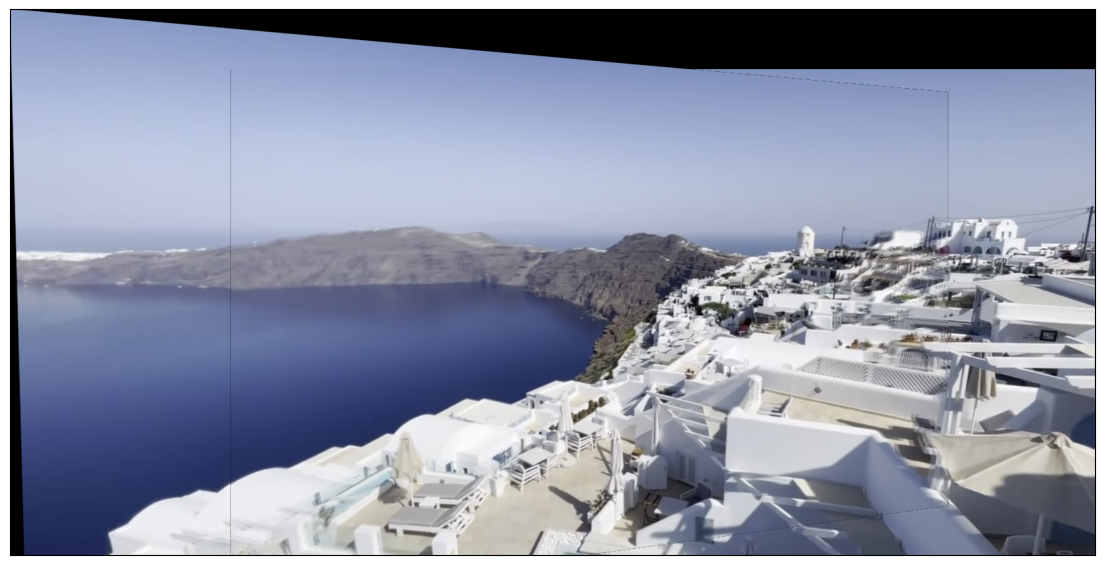

In [28]:
# Transform bounding box
iy,ix = img2.shape[:2]
ib = rect(ix, iy)
ih = homogenize(ib)
th = M @ ih
tp = unhomogenize(th)

# Transformed bounding box
t_x_min = tp[:,0].min()
t_y_min = tp[:,1].min()
t_x_max = tp[:,0].max()
t_y_max = tp[:,1].max()

x_min = min(0, t_x_min)
x_max = max(ix, t_x_max)
y_min = min(0, t_y_min)
y_max = max(iy, t_y_max)
x_w = x_max - x_min
y_w = y_max - y_min
x_w = x_w.astype(np.int32)
y_w = y_w.astype(np.int32)

T = np.array([
    [1, 0, -x_min],
    [0, 1, -y_min]
], dtype=np.float32)
U = np.array([
    [1, 0, -x_min],
    [0, 1, -y_min],
    [0, 0, 1     ]
], dtype=np.float32)

img_t = cv2.warpAffine(img, T, (x_w, y_w)).astype(np.float32)
img2_t = cv2.warpPerspective(img2, U@M, (x_w,y_w)).astype(np.float32)

img_region = lambda im: (im > 0).all(axis=2).astype(np.float32)


weight_mask = img_region(img_t) + img_region(img2_t)
weight_mask[weight_mask == 0] = 1
stitched = (img_t + img2_t) / weight_mask[:,:,np.newaxis]
stitched = np.clip(stitched, 0, 255).astype(np.uint8)

disprgb(stitched)

And we just do this for each of our frames